# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par intégration

## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la [poutre encastrée](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/0-Deroulement/Poutre-encastree.md). Nous montrons comment calculer les coefficients par intégration. Le but de cet exemple est d'utiliser des fonctionnalités de plus bas niveau que celles disponibles dans la classe `FunctionalChaosAlgorithm`. Cet exemple est le complément de `Exercice-chaos-cantilever-beam-LeastSquares.ipynb`, où nous calculons les coefficients par moindres carrés.


## Introduction

### Décomposition en chaos polynomial
Considèrons un modèle physique $g : \mathbb{R}^p \rightarrow \mathbb{R}$ :
$$
Y = g(\boldsymbol{X})
$$
où $\boldsymbol{X} \in \mathcal{X} \subseteq \mathbb{R}^p$ est un vecteur aléatoire et $Y\in \mathbb{R}$ est une variable aléatoire. 
On considère la transformation $\boldsymbol{Z} = T(\boldsymbol{X})$, où $\boldsymbol{X} \in \mathbb{R}^p$ est le vecteur aléatoire en entrée du modèle physique, $T$ est la transformation iso-probabiliste et $\boldsymbol{Z} \in \mathcal{Z} \subseteq \mathbb{R}^p$ est la variable standardisée. 
On introduit la fonction $h$ définie par :
$$
h(\boldsymbol{z}) = g\left(T^{-1}(\boldsymbol{z})\right) = \left(g \circ T^{-1}\right) (\boldsymbol{z})
$$
pour tout $\boldsymbol{z}\in \mathcal{Z}$. 

La décomposition en polynômes du chaos est :
$$
\widetilde{h}(\boldsymbol{Z}) = \sum_{k = 0}^P a_k \psi_k(\boldsymbol{Z})
$$
pour tout $\boldsymbol{Z}\in \mathcal{Z}$, où $P \in \mathbb{N}$ est le nombre de coefficients dans la décomposition, $a_k \in \mathbb{R}$ est le coefficient, $\psi_k$ est le polynôme multivarié et $\boldsymbol{Z}$ est la variable standardisée. 


### Calcul des coefficients par intégration
Les coefficients de la décomposition minimisent la norme euclidienne du vecteur des résidus ou, de manière équivalent, satisfont l'équation :
$$
a_k = \frac{\langle h, \psi_k \rangle}{\|\psi_k\|^2}
$$
pour $k = 0, ..., P$, où le produit scalaire est 
$$
\langle h, \psi_k \rangle 
= \int_{\mathcal{Z}} h(\boldsymbol{z}) \psi_k(\boldsymbol{z}) f_{\boldsymbol{Z}}(\boldsymbol{z}) d\boldsymbol{z}
$$
où $f_{\boldsymbol{Z}}$ est la loi du vecteur aléatoire $\boldsymbol{Z}$ dans l'espace standard. 
Ce produit scalaire forme un espace de Hilbert sur les fonctions de carré intégrable $\mathbb{L}^2(\mathcal{Z})$. La norme qui en découle est :
$$
\left\|\psi_k\right\|^2 
= \langle \psi_k, \psi_k \rangle 
= \int_{\mathcal{Z}} \psi_k(\boldsymbol{z})^2 f_{\boldsymbol{Z}}(\boldsymbol{z}) d\boldsymbol{z}
$$
pour $k = 0, ..., P$. De plus, les fonctions de base $\{\psi_k\}_{k = 0, ..., P}$ sont orthonormales, donc : 
$$
\|\psi_k\| = 1
$$
ce qui implique 
$$
a_k = \langle h, \psi_k \rangle
$$
pour $k = 0, ..., P$. 



## Estimation des intégrales du chaos polynomial par quadrature

### Introduction
La méthode de calcul des coefficients par intégration consiste à évaluer les intégrales associées au produit scalaire et permettant de déterminer les coefficients $\{a_k\}_{k = 0, ..., P}$. Cela représente par conséquent $P + 1$ intégrales en dimension $p$. On peut calculer une approximation de ces intégrales par des méthodes d'intégration numérique comme, par exemple, la méthode de Monte-Carlo, un plan d'expériences de type Latin Hypercube Sampling (LHS), une séquence à faible discrépance (comme par exemple la séquence de Sobol'), la quadrature de Gauss tensorisée ou encore la quadrature de Smolyak. 

### Quadrature
Considérons l'intégrale :
$$
\int_{\mathcal{Z}} h(\boldsymbol{z}) f_{\boldsymbol{Z}} (\boldsymbol{z}) d\boldsymbol{z}
$$
où $h$ est l'intégrande et $f_{\boldsymbol{Z}}$ est la densité de probabilité du vecteur aléatoire $\boldsymbol{Z}$. 

La méthodes de quadrature est :
$$
\int_{\mathcal{Z}} h(\boldsymbol{z}) f_{\boldsymbol{Z}} (\boldsymbol{z}) d\boldsymbol{z}
\approx \sum_{j = 1}^n w^{(j)} h\left(\boldsymbol{z}^{(j)}\right)
$$
où $n$ est le nombre de noeuds, $\{w^{(j)} \geq 0\}_{j = 1, ..., n}$ sont les poids de la quadrature et $\{\boldsymbol{z}^{(j)}\}_{j = 1, ..., n}$ sont les noeuds.

Dans l'exemple ci-dessous, nous utilisons la quadrature de Gauss tensorisée. 

### Estimation des coefficients du chaos polynomial par quadrature
On applique la méthode précédente au cas particulier des coefficients du chaos polynomial. Pour $k = 0, ..., P$., on a :
$$
a_k 
\approx \sum_{j = 1}^n w^{(j)} h\left(\boldsymbol{z}^{(j)}\right) \psi_k\left(\boldsymbol{z}^{(j)}\right)
$$
où $h\left(\boldsymbol{z}\right) = g(T(\left(\boldsymbol{z}\right))$ est le modèle physique dans l'espace standard et $\{\psi_k\}_{k = 0, ..., P}$ sont les polynômes multivariés orthonormaux. Pour évaluer la somme suivante, il peut être pratique d'évaluer le produit scalaire du vecteur des poids par un vecteur bien choisi. Cela peut permettre d'améliorer la performance en vectorisant le calcul. Soit $\boldsymbol{w} \in \mathbb{R}^n$ le vecteur des poids. Soit $\boldsymbol{s}\in \mathbb{R}^n$ le vecteur défini par :
$$
s_j = h\left(\boldsymbol{z}^{(j)}\right) \psi_k\left(\boldsymbol{z}^{(j)}\right)
$$
pour $j = 1, ..., n$. Alors :
$$
a_k 
\approx \left\langle \boldsymbol{w}, \; \boldsymbol{s}\right\rangle
$$
où $\left\langle \cdot, \cdot\right\rangle$ est le produit scalaire vectoriel.



## Application avec OpenTURNS

Dans cette section, on applique la méthode précédente de deux manières différentes:
- avec la classe `FunctionalChaosAlgorithm`,
- en "ouvrant la boîte", avec les classes `Experiment`.

### Partie 1 : avec la classe FunctionalChaosAlgorithm

In [1]:
import openturns as ot
import openturns.viewer as otv

In [2]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # En mètres
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
distributionI.setDescription(["I"])

myDistribution = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L**3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

### Créer le polynôme

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [3]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [distributionE, distributionF, distributionL, distributionI]
)

Nous devons une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `maximumBasisSize` en utilisant la méthode  `getBasisSizeFromTotalDegree`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. 

In [4]:
totalDegree = 2
enumerateFunction = multivariateBasis.getEnumerateFunction()
maximumBasisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=15

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

Nous définissons maintenant la règle de calcul des coefficients ; nous choisissons la méthode par intégration. Les coefficients sont estimés dans l'espace standard, associé au variables $\boldsymbol{Z} = T(\boldsymbol{X})$, où $\boldsymbol{X} \in \mathbb{R}^p$ est le vecteur aléatoire en entrée du modèle physique, $T$ est la transformation iso-probabiliste t $\boldsymbol{Z}$ est la variable standardisée. Cette transformation iso-probabiliste permet, parmi d'autres avantages, d'utiliser la famille des polynômes orthogonaux classiques. C'est pourquoi la méthode d'intégration doit générer des noeuds dans l'espace standard des $\boldsymbol{Z}$. 

On commence par obtenir la mesure standard associée à la base polynomiale multivariée. On observe que l'intervalle de définition de la loi `Beta` est standardisée entre -1 et 1. Il en est de même pour la loi `Uniform` et la seconde loi `Beta`.

In [5]:
distributionStandard = multivariateBasis.getMeasure()
distributionStandard

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 2.2, a = -1, b = 1)"
1,X0,"LogNormal(muLog = 9.46206, sigmaLog = 0.554513, gamma = 0)"
2,L,"Uniform(a = -1, b = 1)"
3,I,"Beta(alpha = 2.5, beta = 1.5, a = -1, b = 1)"


In [6]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(myDistribution, marginalSize)

On peut observer la taille du plan d'expériences associé.

In [7]:
inputSample, weights = experiment.generateWithWeights()
inputSample.getSize()

256

In [8]:
outputSample = g(inputSample)
outputSample[:5]

,y0
0,12.99625
1,11.35191
2,9.600731
3,8.393954
4,21.14073


On observe que la règle de quadrature est associée à un plan d'expériences de taille 256.

In [9]:
projectionStrategy = ot.IntegrationStrategy(experiment)

On peut maintenant créer le chaos fonctionnel. 

In [10]:
chaosalgo = ot.FunctionalChaosAlgorithm(
    inputSample,
    weights,
    outputSample,
    myDistribution,
    adaptiveStrategy,
    projectionStrategy,
)
chaosalgo.run()

Get the result


In [11]:
result = chaosalgo.getResult()
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[1,0,0,0]",-1.552065
2,"[0,1,0,0]",3.787392
3,"[0,0,1,0]",0.4286234
4,"[0,0,0,1]",-0.9992086
5,"[2,0,0,0]",0.2021305
6,"[1,1,0,0]",-0.4656196
7,"[1,0,1,0]",-0.0526947
8,"[1,0,0,1]",0.1228421
9,"[0,2,0,0]",-8.595609e-15


La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [12]:
metamodel = result.getMetaModel()

### Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [13]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [14]:
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))

Compute the $Q^2$ predictivity coefficient

In [15]:
Q2 = val.computeR2Score()[0]
Q2 = max(0.0, min(1.0, Q2))
Q2

0.9995427446350182

Plot the observed versus the predicted outputs.

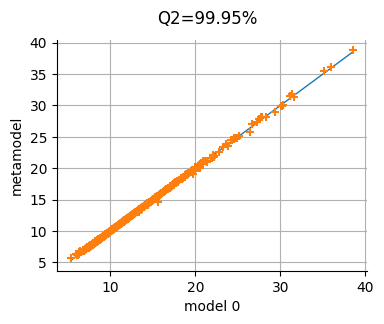

In [16]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que les coefficients sont relativement bien estimés puisque le Q2 est excellent (parfait ?), malgré un nombre de points relativement réduit dans le plan d'expériences (256 points).

## Partie 2 : ouvrons la boîte

Dans cette section, on implémente l'estimation des coefficients du chaos en utilisant les classes de plan d'expériences pour implémenter la quadrature.

Commençons par créer la base polynomiale multivariée.

In [17]:
totalDegree = 2
enumerateFunction = multivariateBasis.getEnumerateFunction()
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
basisSize

15

Dans la cellule suivante, nous créons un plan d'expériences implémentant la quadrature de Gauss tensorisée. Nous utilisons un nombre de noeuds égal à 4 pour chaque dimension, ce qui mène à $4^4 = 256$ noeuds.

In [18]:
marginalSize = [4] * dim_input
experiment = ot.GaussProductExperiment(myDistribution, marginalSize)
inputSample, weights = experiment.generateWithWeights()
outputSample = g(inputSample)
sampleSize = inputSample.getSize()
sampleSize

256

Nous créons ensuite la transformation iso-probabiliste $T$ et son inverse.

In [19]:
distributionStandard = multivariateBasis.getMeasure()
transformation = ot.DistributionTransformation(myDistribution, distributionStandard)
standardSample = transformation(inputSample)
inverseTransformation = transformation.inverse()

La cellule suivante est le coeur de la méthode. Nous évaluons chaque coefficient associé à la décomposition en chaos polynomial. Pour chaque fonction, on évalue l'intégrande qui est égale au produit de la fonction de la base fonctionnelle et du modèle physique. Enfin, le coefficient est évalué en fonction du produit scalaire formé par le vecteur des valeurs de l'intégrande et des poids de la quadrature.

In [20]:
outputDimension = 1
coefficients = ot.Sample(basisSize, outputDimension)
functionalBasis = []
for k in range(basisSize):
    basisFunction = multivariateBasis.build(k)
    functionalBasis.append(basisFunction)
    basisValue = basisFunction(standardSample)
    integrandValue = ot.Point(
        [basisValue[j, 0] * outputSample[j, 0] for j in range(sampleSize)]
    )
    coefficients[k, 0] = integrandValue.dot(weights)
coefficients[:10]

,v0
0,12.62464
1,-1.552065
2,3.787392
3,0.4286234
4,-0.9992086
5,0.2021305
6,-0.4656196
7,-0.0526947
8,0.1228421
9,-8.664131e-15


Enfin, nous créons le `FunctionalChaosResult`, ce qui simplifie la suite de l'analyse et l'utilisaton concrète du chaos polynomial.

In [21]:
indices = range(basisSize)
pceResult = ot.FunctionalChaosResult(
    inputSample,
    outputSample,
    myDistribution,
    transformation,
    inverseTransformation,
    multivariateBasis,
    indices,
    coefficients,
    functionalBasis,
)
pceResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[1,0,0,0]",-1.552065
2,"[0,1,0,0]",3.787392
3,"[0,0,1,0]",0.4286234
4,"[0,0,0,1]",-0.9992086
5,"[2,0,0,0]",0.2021305
6,"[1,1,0,0]",-0.4656196
7,"[1,0,1,0]",-0.0526947
8,"[1,0,0,1]",0.1228421
9,"[0,2,0,0]",-8.664131e-15


Dans la cellule suivante, nous validons le métamodèle.

In [22]:
metamodel = pceResult.getMetaModel()
sampleSizeValidation = 10000
inputTest = myDistribution.getSample(sampleSizeValidation)
outputTest = g(inputTest)
# Validate
val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
q2Score = val.computeR2Score()[0]
q2Score

0.9995991362612449

## Exercice 1 : changer de méthode de quadrature

Dans cet exercice, on souhaite expérimenter d'autres méthodes de quadrature. Dans OpenTURNS, la classe `WeightedExperiment` est la classe mère pour tous les plans d'expériences appropriés pour approcher une intégrale multi-dimensionnelle. Pour utiliser les classes filles de la classe `WeightedExperiment`, on peut évaluer la méthode  `generateWithWeights`, qui a la séquence d'appel suivante :
```
nodes, weights = experiment.generateWithWeights()
```
où `nodes` est un `Sample` représentant les noeuds de la quadrature et `weights` est un `Point` représentant les poids de la quadrature. Pour utiliser la méthode de quadrature, on évalue l'intégrande et on réalise le produit scalaire avec le vecteur des poids :
```
g_values = g_function(nodes).asPoint()
approximate_integral = g_values.dot(weights)
```
Puisque ces plans d'expériences sont associés à une densité de probabilité, leur constructeur nécessite une `Distribution` en entrée de la classe. 

En conséquence, toutes ses classes dérivées sont éligibles pour estimer les coefficients du chaos polynomial, comme par exemple la classe `MonteCarloExperiment`. 

_Questions_

- Utiliser la classe `MonteCarloExperiment` pour estimer les coefficients du chaos polynomial par Monte-Carlo simple. Pour cela, utiliser un échantillon d'apprentissage de taille $n = 1000$. Calculer le score de prédictivité $Q^2$ avec un échantillon de test. Quels sont les avantages et inconvénients de cette méthode ? 
- Répéter l'expérience précédente avec la classe `LHSExperiment`. A quel point les résultats sont-ils modifiés ?
- Utiliser la classe `LowDiscrepancyExperiment` pour estimer les coefficients du chaos polynomial par une séquence à faible discrépance. Pour cela, utiliser la séquence de Sobol' avec la classe `SobolSequence`. Quelle taille d'échantillon $n$ permet d'obtenir un résultat comparable au résultat de la classe `MonteCarloExperiment` en termes de score Q2 ?

## Exercice 2 : position des noeuds d'une méthode de quadrature

Le but de cet exercice est d'observer les noeuds d'une méthode de quadrature.

_Questions_

- Utiliser la méthode `DrawPairs` pour dessiner les projections bidimensionnelles d'un plan de type `MonteCarloExperiment` associé à la distribution `distributionStandard` avec 50 points. Qu'observez-vous ?
- Faire la même expérience avec un plan de type `LHSExperiment` et `LowDiscrepancyExperiment`. 
- Enfin, observez les points d'un plan de type `GaussProductExperiment`. Qu'observez-vous ?

## Exercice 3 : quadrature de Smolyak

Le but de cet exercice est d'utiliser la quadrature de Smolyak.

_Questions_
- Utiliser la classe `SmolyakExperiment` pour évaluer les coefficients du chaos polynomial. Quel score Q2 obtient-on? Comment cela se compare-t-il aux autres méthodes?
- Utiliser la méthode `DrawPairs` pour dessiner les points du plan d'expériences. Qu'observez-vous?

## Exercice 4 : chaos creux par intégration

On cherche à mettre au point une méthode de chaos polynomial creux par intégration. On considère un chaos polynomial plein avec $P$ coefficients et on recherche un métamodèle avec moins de coefficients permettant d'atteindre un score Q2. Plus précisément, cherche à hiérarchiser les coefficients par ordre décroissant d'importance dans la décomposition.

On compare deux stratégies:
- A : on considère l'importance des coefficients en fonction de l'amélioration du score Q2,
- B : on considère la valeur absolue des coefficients.

Pour implémenter la stratégie A, on considère l'algorithme suivant. 
- On initialise la base active à $\mathcal{A} = \{0\}$. Cela correspond à un développement associé à un seul coefficient, c'est-à-dire $a_0$.
- On évalue le score Q2 correspondant à cette base.
- Pour i allant de 1 à P.
    - On recherche le coefficient inactif $a_k$ permettant d'améliorer le plus le score Q2.
    - Si on a amélioré le score Q2, alors on ajoute $k$ à $\mathcal{A}$ et on met à jour le meilleur score Q2 atteint jusqu'à cette itération.

En sortie de l'algorithme, on obtient dans l'ordre d'activation :
- la liste des indices actifs $\mathcal{A}$ ;
- la liste des scores Q2.

Pour implémenter la stratégie A, on propose d'utiliser les fonctions suivantes.
- `computeIntegrationFullPCECustom` : crée un PCE en utilisant une méthode d'intégration numérique pour évaluer les coefficients
- `pce2SparsePce` : crée un PCE creux à partir d'un PCE plein et d'une liste de booléens d'activation.

Analysons maintenant la stratégie B : on évalue la valeur absolue des coefficients et on trie ces valeurs absolues par ordre décroissants. La liste hiérarchisée des indices est l'indice des coefficients. 

_Questions_
- Implémenter la stratégie A. Observer la liste des indices des coefficients.
- Implémenter la stratégie B. Pour cela, utiliser la méthode `Sample.argsort`.
- Comparer les deux stratégies : qu'observez-vous ? Pourquoi ?

In [23]:
def computeIntegrationFullPCECustom(
    g_function, multivariateBasis, totalDegree, myDistribution, experiment
):
    """
    Create a full polynomial chaos with integration based on an experiment.

    * Uses the enumeration rule from multivariateBasis.
    * Uses IntegrationStrategy to compute the coefficients using
    integration.
    * Uses FixedStrategy to keep all coefficients.

    When the number of input variables
    or the required marginal degree is large, the design of experiments is
    very large.

    Parameters
    ----------
    g_function : ot.Function
        The function to create the metamodel from.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree.
        The total degree is the sum of the marginal degrees.
    myDistribution : ot.Distribution
        The distribution of the input random vector
    experiment : ot.WeightedExperiment
        The design of experiment for quadrature

    Returns
    -------
    pceResult : ot.FunctionalChaosResult
        The polynomial chaos expansion
    """
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
    inputSample, weights = experiment.generateWithWeights()
    outputSample = g_function(inputSample)
    sampleSize = inputSample.getSize()
    distributionStandard = multivariateBasis.getMeasure()
    transformation = ot.DistributionTransformation(myDistribution, distributionStandard)
    standardSample = transformation(inputSample)
    inverseTransformation = transformation.inverse()
    outputDimension = 1
    coefficients = ot.Sample(basisSize, outputDimension)
    functionalBasis = []
    for k in range(basisSize):
        basisFunction = multivariateBasis.build(k)
        functionalBasis.append(basisFunction)
        basisValue = basisFunction(standardSample)
        integrandValue = ot.Point(
            [basisValue[j, 0] * outputSample[j, 0] for j in range(sampleSize)]
        )
        coefficients[k, 0] = integrandValue.dot(weights)
    indices = range(basisSize)
    pceResult = ot.FunctionalChaosResult(
        inputSample,
        outputSample,
        myDistribution,
        transformation,
        inverseTransformation,
        multivariateBasis,
        indices,
        coefficients,
        functionalBasis,
    )
    return pceResult

In [24]:
def pce2SparsePce(pceResult, activeIndices):
    """
    Create a sparse PCE from a full PCE

    Parameters
    ----------
    pceResult : ot.FunctionalChaosResult
        The full PCE
    activeIndices : list(int)
        The list of active indices in the sparse PCE

    Returns
    -------
    sparsePceResult : ot.FunctionalChaosResult
        The full PCE
    """
    # Extract the fields
    coefficients = pceResult.getCoefficients()
    numberOfCoefficients = coefficients.getSize()
    inputSample = pceResult.getInputSample()
    outputSample = pceResult.getOutputSample()
    distribution = pceResult.getDistribution()
    transformation = pceResult.getTransformation()
    inverseTransformation = pceResult.getInverseTransformation()
    multivariateBasis = pceResult.getOrthogonalBasis()
    functionalBasis = pceResult.getReducedBasis()

    #
    activeIndices = ot.Indices(activeIndices)
    activeIndices.check(numberOfCoefficients)

    # Select active components
    activeCoefficients = ot.Sample(0, 1)
    activeFunctionalBasis = []
    for k in activeIndices:
        activeCoefficients.add(coefficients[k])
        activeFunctionalBasis.append(functionalBasis[k])

    # Create the sparse PCE
    sparsePceResult = ot.FunctionalChaosResult(
        inputSample,
        outputSample,
        distribution,
        transformation,
        inverseTransformation,
        multivariateBasis,
        activeIndices,
        activeCoefficients,
        activeFunctionalBasis,
    )

    return sparsePceResult

In [25]:
totalDegree = 2
fullPCEResult = computeIntegrationFullPCECustom(
    g, multivariateBasis, totalDegree, myDistribution, experiment
)
fullPCEResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[1,0,0,0]",-1.552065
2,"[0,1,0,0]",3.787392
3,"[0,0,1,0]",0.4286234
4,"[0,0,0,1]",-0.9992086
5,"[2,0,0,0]",0.2021305
6,"[1,1,0,0]",-0.4656196
7,"[1,0,1,0]",-0.0526947
8,"[1,0,0,1]",0.1228421
9,"[0,2,0,0]",-8.664131e-15


In [26]:
metamodel = fullPCEResult.getMetaModel()
sampleSizeValidation = 10000
inputTest = myDistribution.getSample(sampleSizeValidation)
outputTest = g(inputTest)

val = ot.MetaModelValidation(outputTest, metamodel(inputTest))
q2Score = val.computeR2Score()[0]
q2Score

0.9995650405040906

In [27]:
coefficients = fullPCEResult.getCoefficients()
numberOfCoefficients = coefficients.getSize()
activeIndices = [0, 2, 1, 4, 6, 3, 11, 5, 10, 8, 14, 7, 13]
sparsePCEResult = pce2SparsePce(fullPCEResult, activeIndices)
sparsePCEResult

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.62464
1,"[0,1,0,0]",3.787392
2,"[1,0,0,0]",-1.552065
3,"[0,0,0,1]",-0.9992086
4,"[1,1,0,0]",-0.4656196
5,"[0,0,1,0]",0.4286234
6,"[0,1,0,1]",-0.2997626
7,"[2,0,0,0]",0.2021305
8,"[0,1,1,0]",0.128587
9,"[1,0,0,1]",0.1228421
